In [1]:
import torch
import matplotlib.pyplot as plt
import scipy

# Over- and under-determined inverse problems

Consider a system $Ku = f$ with:

In [2]:
K = torch.tensor([
    [1.0, 1.0],
    [2.0, 1.0],
    [1.0, 2.0]
])
f = torch.tensor([1.0, 1.0, 1.0])

It is evidently not consistent and solution does not exist:

In [3]:
print(f'rank(K) = {torch.linalg.matrix_rank(K)} < {f.nelement()}')

rank(K) = 2 < 3


However, there is a unique solution to the system by the normal equations $K^\top K u = K^\top f$:

In [4]:
print('KTK:')
print(K.T @ K)
print('KTf:')
print(K.T @ f)
print('u:')
print(torch.inverse(K.T @ K) @ (K.T @ f))

KTK:
tensor([[6., 5.],
        [5., 6.]])
KTf:
tensor([4., 4.])
u:
tensor([0.3636, 0.3636])


On the other hand, for a system $Ku = f$ with:

In [5]:
K = torch.tensor([
    [1.0, 2.0, 3.0],
    [2.0, 5.0, 7.0]
])
f = torch.tensor([4.0, 8.0])

is underdetermined, and there are infinitely many solutions. In this case, the normal equations give a solution with the smallest Euclidean norm:

In [6]:
print(K.T @ torch.inverse(K @ K.T) @ f)

tensor([ 2.6666, -1.3333,  1.3333])


In both cases the normal equations correspond to the Moore-Penrose pseudoinverse, that can be calculated using `torch.linalg.pinv`:

In [7]:
print('Over-determined case')
print('---')
K = torch.tensor([
    [1.0, 1.0],
    [2.0, 1.0],
    [1.0, 2.0]
])
f = torch.tensor([1.0, 1.0, 1.0])
print('Normal equations:')
print(torch.inverse(K.T @ K) @ K.T)
print('Pseudoinverse:')
print(torch.linalg.pinv(K))

print()

print('Under-determined case')
print('---')
K = torch.tensor([
    [1.0, 2.0, 3.0],
    [2.0, 5.0, 7.0]
])
f = torch.tensor([4.0, 8.0])
print('Normal equations:')
print(K.T @ torch.inverse(K @ K.T))
print('Pseudoinverse:')
print(torch.linalg.pinv(K))

Over-determined case
---
Normal equations:
tensor([[ 0.0909,  0.6364, -0.3636],
        [ 0.0909, -0.3636,  0.6364]])
Pseudoinverse:
tensor([[ 0.0909,  0.6364, -0.3636],
        [ 0.0909, -0.3636,  0.6364]])

Under-determined case
---
Normal equations:
tensor([[ 3.9999, -1.6666],
        [-2.9999,  1.3333],
        [ 1.0000, -0.3333]])
Pseudoinverse:
tensor([[ 4.0000, -1.6667],
        [-3.0000,  1.3333],
        [ 1.0000, -0.3333]])


# Regularization

Let us try to solve a deconvolution problem $Ku = f$, where $K$ is a Toeplitz matrix with elements

$$k_{ij} = \frac{\exp((i-j)^2 / {2 \sigma^2})}{n \sigma  \sqrt{2\pi}},$$

so basically Gaussian blurring. As an object, we will use a step function defined by

$$u(x) = H(x - 0.3) - H(x - 0.7),$$

where $H$ is the Heaviside step function.

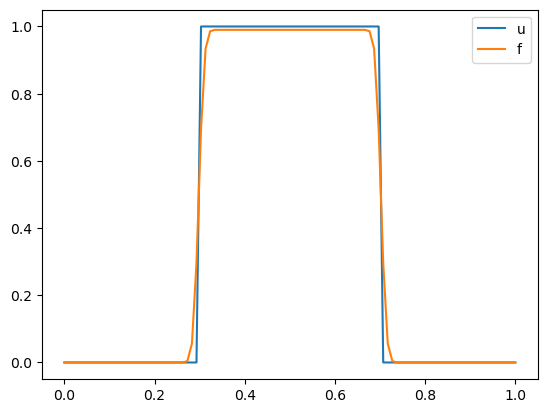

In [8]:
# Parameters and grid
n = 100
sigma = 0.01
x = torch.linspace(0, 1, n)

# Define the forward operator
c = torch.exp(-x**2 / (2 * sigma**2)) / (n * sigma * (2 * torch.pi)**0.5)
K = torch.tensor(scipy.linalg.toeplitz(c))

# The object and the observation
u = (torch.abs(x - 0.5) < 0.2).to(torch.float32)
f = K @ u

# Visualize
plt.plot(x, u, label='u')
plt.plot(x, f, label='f')
plt.legend()

To recover $u$ from the measurement $f$, we can compute the (pseudo)inverse of $K$ and apply it to $f$:

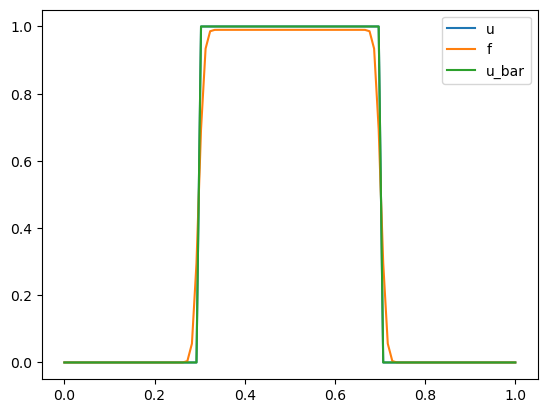

In [9]:
U, S, Vh = torch.linalg.svd(K)
K_pinv = Vh.T @ torch.diag(1/S) @ U.T
plt.plot(x, u, label='u')
plt.plot(x, f, label='f')
plt.plot(x, K_pinv @ f, label='u_bar')
plt.legend()

This works great, but unfortunately is not realistic, since there's no noise. Let's add some and see what happens.

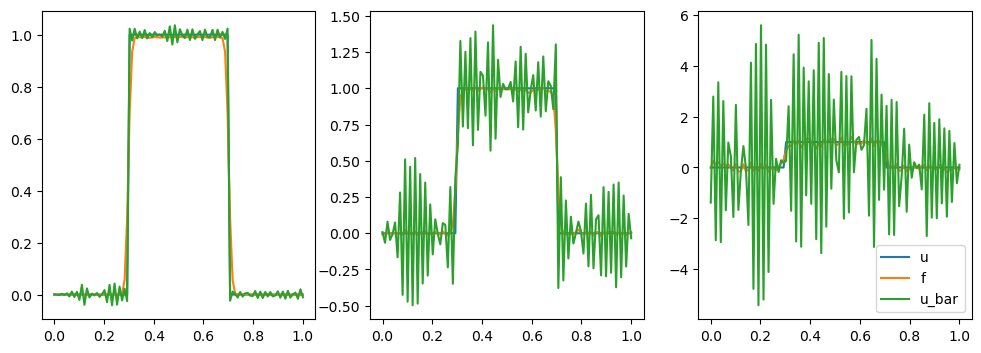

In [10]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=[12, 4])
for i, noise_level in enumerate([0.001, 0.01, 0.1]):
    f_noisy = f + noise_level * torch.randn(size=f.shape)

    axes[i].plot(x, u, label='u')
    axes[i].plot(x, f_noisy, label='f')
    axes[i].plot(x, K_pinv @ f_noisy, label='u_bar')
axes[-1].legend()

As we can, see the noise is amplified dramatically, because the problem is ill-posed. To address this, we can employ regularization using truncated SVD:

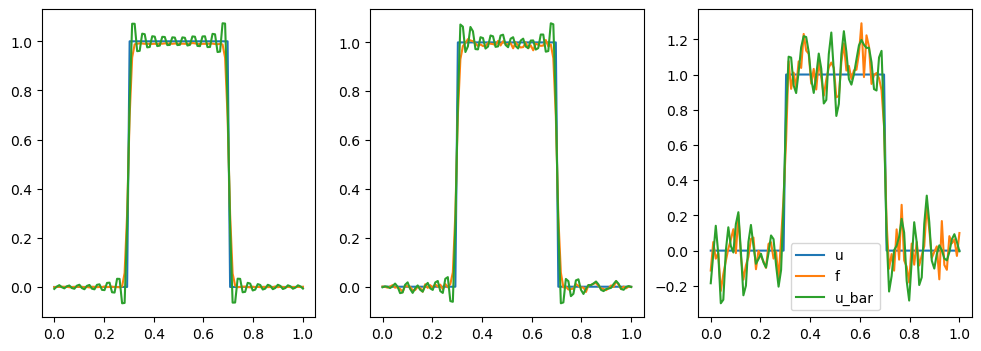

In [11]:
# Select k largest values from the full SVD
k = 50
Sk = S[:k]
Uk = U[:, :k]
Vhk = Vh[:k, :]
K_inv_tsvd = Vhk.T @ torch.diag(1/Sk) @ Uk.T

# Test the truncated SVD regularization on noisy data
_, axes = plt.subplots(nrows=1, ncols=3, figsize=[12, 4])
for i, noise_level in enumerate([0.001, 0.01, 0.1]):
    f_noisy = f + noise_level * torch.randn(size=f.shape)

    axes[i].plot(x, u, label='u')
    axes[i].plot(x, f_noisy, label='f')
    axes[i].plot(x, K_inv_tsvd @ f_noisy, label='u_bar')
axes[-1].legend()

Now the noise amplification is much more limited! However, we start observing systematic artifacts, because the solution is now biased towards singular vectors corresponding to larger singular numbers (low frequency oscillations in case of this problem):

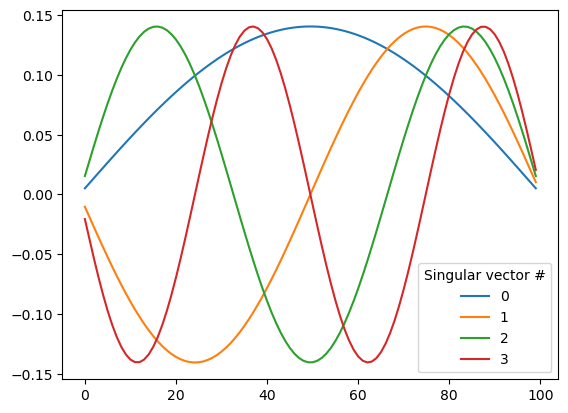

In [12]:
plt.plot(U[:, 0:4])
plt.legend(range(4), title='Singular vector #')
plt.show()

This is a typical example of the bias-variance tradeoff.